# Steps
1- Realease the particles (2_PT_seseflux)
2- Read the particles for each month 
3- reduce to firs particles intersection to coastline, delete the ones that does not interact with coastline 
4- we make a dataframe that only include the particles first intersect with the shoreline for each month 
- another thing we need to add is to add a group_number to the particles in addition that group_id like 11, 12, 13


# Import required Libraries

In [1]:
# Importing libraries
import warnings 
import os
import glob
import xarray as xr
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import gc
from shapely.geometry import Point
# Enable Dask progress bar
from dask.diagnostics import ProgressBar

In [88]:
output_path = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results'

# Reading Input files

In [13]:
# read the coastal wetland shapefile
CW_path ='/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline'
CW_avg = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

In [20]:
# Ensure the shapefiles are GeoDataFrames
CW_avg = gpd.read_file(CW_avg)
CW_low = gpd.read_file(CW_low)
CW_high = gpd.read_file(CW_high)
CW_surge = gpd.read_file(CW_surge)


In [7]:
# Define the path to the data directory
data_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output'
def sort_key(file):
    filename = os.path.basename(file)
    number = int(filename.split('__')[1].split('.')[0])
    return number
files = glob.glob(data_dir + "/updated_Fvcome_huron_estuary_2023_Winter_*.nc")
files.sort(key=sort_key)

# (Optional) Print the sorted file names to verify the sorting
for file in files:
    print(file)

/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Jan__1.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Feb__2.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Mar__3.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Apr__4.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_May__5.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Jun__6.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_July__7.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Aug__8.nc
/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/updated_Fvcome_huron_estuary_2023_Winter_Sep__9.nc
/home/abo

# 1- make a geodataframe for particle tracking files

In [3]:
ds = xr.open_mfdataset(files[0], engine='netcdf4', combine='by_coords')

#selected_vars = ds[['time', 'group_id', 'group_number', 'longitude', 'latitude']]
#stacked_data = selected_vars.stack(particle_time=('time', 'particles'))


In [5]:
# Open multiple NetCDF datasets with chunks using xarray
# Suppress FutureWarnings related to pandas unique
warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")

# Open multiple NetCDF datasets with chunks using xarray
datasets = xr.open_mfdataset(files, combine='by_coords', parallel=True)

# Select relevant variables: time, group_id, group_number, longitude, latitude
selected_vars = datasets[['time', 'group_id', 'group_number', 'longitude', 'latitude']]
# Stack across 'time' and 'particles', dropping unwanted dimensions
#stacked_data = selected_vars.stack(particle_time=('time', 'particles')).drop_dims('dim_0', errors='ignore')
# Stack across 'time' and 'particles', dropping unwanted dimensions

stacked_vars = selected_vars.stack(particle_time=('time', 'particles'))

stacked_data['longitude'].values = stacked_data['longitude'].values - 360

In [9]:
stacked_data['group_number']

<xarray.DataArray 'group_number' (particle_time: 6608250)> Size: 132MB
dask.array<reshape, shape=(6608250,), dtype=<U5, chunksize=(598950,), chunktype=numpy.ndarray>
Coordinates:
  * particle_time  (particle_time) object 53MB MultiIndex
  * time           (particle_time) datetime64[ns] 53MB 2023-01-01 ... 2023-12-31
  * particles      (particle_time) int64 53MB 0 1 2 3 4 ... 4946 4947 4948 4949

In [11]:
# convert the stacked data to a pandas dataframe
df = stacked_data.to_dataframe()
df

group_id group_number   longitude   latitude       time  \
time       particles                                                            
2023-01-01 0                 0          000  -84.665833  45.755062 2023-01-01   
           1                 0          001  -84.671844  45.749062 2023-01-01   
           2                 0          002  -84.673828  45.749062 2023-01-01   
           3                 0          003  -84.657837  45.747059 2023-01-01   
           4                 0          004  -84.659851  45.747059 2023-01-01   
...                        ...          ...         ...        ...        ...   
2023-12-31 4945            147        14743  -83.594055  43.653458 2023-12-31   
           4946            147        14744  -83.596680  43.651913 2023-12-31   
           4947            147        14745  -83.439728  43.770046 2023-12-31   
           4948            147        14746 -443.591553  43.655369 2023-12-31   
           4949            147        14747  -83.595154  43.652771 2023-12-31   

                      particles  
time       particles             
2023-01-01 0                  0  
           1                  1  
           2                  2  
           3                  3  
           4                  4  
...                         ...  
2023-12-31 4945            4945  
           4946            4946  
           4947            4947  
           4948            4948  
           4949            4949  

[6608250 rows x 6 columns]

## 1-2 Covert df to geodataframe


In [54]:
# conver the pandas dataframe to geodataframe
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf


group_id group_number   longitude   latitude       time  \
time       particles                                                            
2023-01-01 0                 0          000  -84.665833  45.755062 2023-01-01   
           1                 0          001  -84.671844  45.749062 2023-01-01   
           2                 0          002  -84.673828  45.749062 2023-01-01   
           3                 0          003  -84.657837  45.747059 2023-01-01   
           4                 0          004  -84.659851  45.747059 2023-01-01   
...                        ...          ...         ...        ...        ...   
2023-12-31 4945            147        14743  -83.594055  43.653458 2023-12-31   
           4946            147        14744  -83.596680  43.651913 2023-12-31   
           4947            147        14745  -83.439728  43.770046 2023-12-31   
           4948            147        14746 -443.591553  43.655369 2023-12-31   
           4949            147        14747  -83.595154  43.652771 2023-12-31   

                      particles                     geometry  
time       particles                                          
2023-01-01 0                  0   POINT (-84.66583 45.75506)  
           1                  1   POINT (-84.67184 45.74906)  
           2                  2   POINT (-84.67383 45.74906)  
           3                  3   POINT (-84.65784 45.74706)  
           4                  4   POINT (-84.65985 45.74706)  
...                         ...                          ...  
2023-12-31 4945            4945   POINT (-83.59406 43.65346)  
           4946            4946   POINT (-83.59668 43.65191)  
           4947            4947   POINT (-83.43973 43.77005)  
           4948            4948  POINT (-443.59155 43.65537)  
           4949            4949   POINT (-83.59515 43.65277)  

[6608250 rows x 7 columns]

In [50]:
# print gdf columns to see the columns
gdf['time']

time        particles
2023-01-01  0           2023-01-01
            1           2023-01-01
            2           2023-01-01
            3           2023-01-01
            4           2023-01-01
                           ...    
2023-12-31  4945        2023-12-31
            4946        2023-12-31
            4947        2023-12-31
            4948        2023-12-31
            4949        2023-12-31
Name: time, Length: 6608250, dtype: datetime64[ns]

# 3-Find intersection of particle tracking with coastal wetlands

In [57]:

import pandas as pd
import geopandas as gpd

# Step 1: Ensure 'time' and 'particles' are not both an index and a column
if 'time' in CW_avg_intersections.index.names:
    CW_avg_intersections = CW_avg_intersections.reset_index(drop=False)

# Step 2: Sort the GeoDataFrame by 'group_id' and 'group_number'
CW_avg_intersections = CW_avg_intersections.sort_values(by=['group_id', 'group_number'])

# Step 3: Group by 'group_number' to find the first intersection for each group
first_intersections = CW_avg_intersections.groupby('group_number').first().reset_index()

# Step 4: Count the number of occurrences of each unique 'group_id'
group_id_counts = CW_avg_intersections.groupby('group_id').size().reset_index(name='count')

# Step 5: Print the result of group_id counts
print(group_id_counts)

# Optional: Save the first_intersections and group_id counts to CSV files
first_intersections.to_csv('first_intersections.csv', index=False)
group_id_counts.to_csv('group_id_counts.csv', index=False)

print("First intersections and group_id counts saved.")



     group_id  count
0           0    140
1           2    136
2           3    254
3           4    388
4           5    482
..        ...    ...
122       127   1238
123       128   3602
124       129    575
125       130   5876
126       147  13107

[127 rows x 2 columns]
First intersections and group_id counts saved.


# 4-Plot 

Average number of particles entering the Coastal Wetland: 3540.0
Percentage of particles from total trajectories that remain in the Coastal Wetland: 100.00%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 particles
Bin 35:

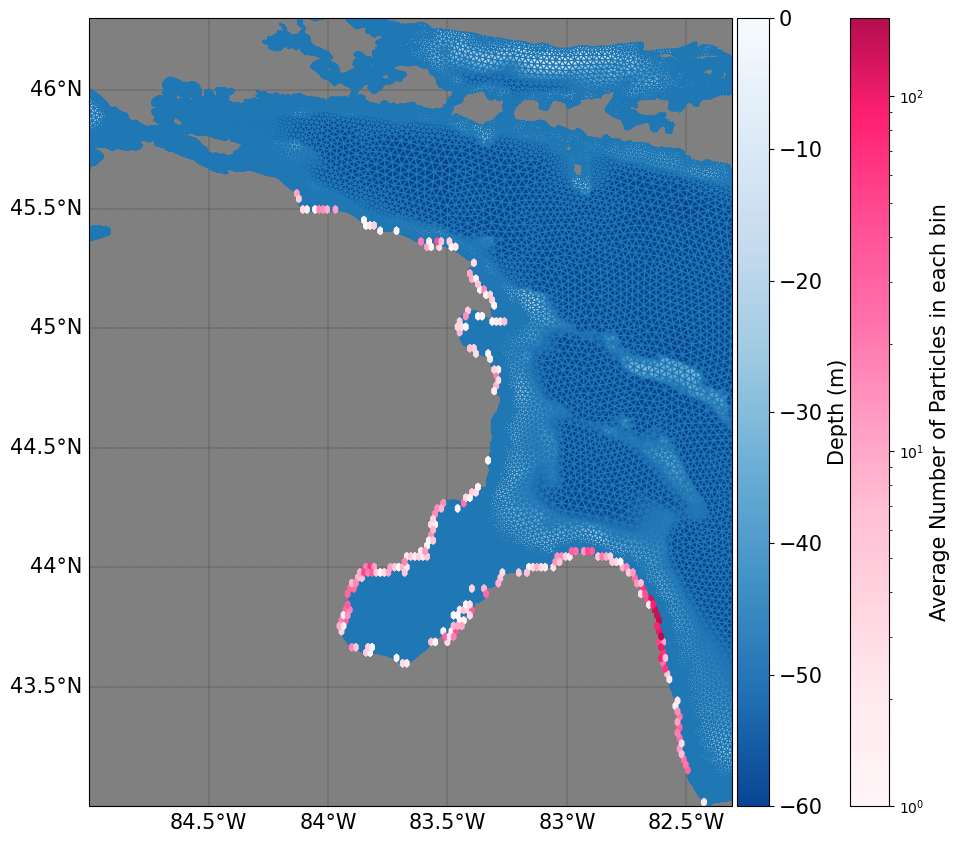

In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)

# Initialize variables
all_bin_counts = []
all_coords = []

# Assuming 'first_intersections' contains the geometries of the first particle hits
all_coords.extend(zip(first_intersections['geometry'].x, first_intersections['geometry'].y))

# Set up plotting parameters
font_size = 15
cmap = colourmap('h_r')

# Create figure and axis
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data from NetCDF
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder=0)

# Overlay grid on the plot
plotter.draw_grid(ax, linewidth=1.0)

# Initialize the hexbin grid based on the particle positions
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize variables to store results across months
accumulated_bin_counts = np.zeros(len(hexbin_grid))
total_particles_intersecting_CW = 0
total_particles_tracked = 0
total_particles_list = []
points_within_CW_list = []

# Iterate over the first intersections and accumulate data
hb = ax.hexbin(first_intersections['geometry'].x, first_intersections['geometry'].y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)
bin_counts = hb.get_array()

# Accumulate bin counts
for i, count in enumerate(bin_counts):
    accumulated_bin_counts[i] += count

# Count the total particles intersecting with CW
total_particles_intersecting_CW += first_intersections['group_number'].nunique()
total_particles_tracked += first_intersections['group_number'].nunique()  # Assuming you're tracking based on 'group_id'

# Track total particles and those within CW
total_particles_list.append(first_intersections.shape[0])
points_within_CW_list.append(first_intersections.shape[0])

# Calculate the average bin counts over the months
average_bin_counts = accumulated_bin_counts / len(total_particles_list)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_CW = total_particles_intersecting_CW / len(total_particles_list)

# Calculate the percentage of particles that remain in the shoreline buffer
percentage_particles_remain_in_CW = (total_particles_intersecting_CW / total_particles_tracked) * 100

# Output calculated values
print(f'Average number of particles entering the Coastal Wetland: {average_particles_entering_CW}')
print(f'Percentage of particles from total trajectories that remain in the Coastal Wetland: {percentage_particles_remain_in_CW:.2f}%')

# Update the hexbin plot with the average bin counts
hb = ax.hexbin(*zip(*hexbin_grid), gridsize=100, C=average_bin_counts, cmap=pink_cmap, norm=LogNorm(), zorder=40)

# Print the average number of particles in each bin
print("Average number of particles in each bin:")
for i, count in enumerate(average_bin_counts):
    print(f"Bin {i}: {count:.2f} particles")

# Set the axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar to represent the average number of particles per bin
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Average Number of Particles in each bin', fontsize=15)

# Adjust the plot layout for the colorbar
plt.subplots_adjust(right=1)

# Show the plot
plt.show()

# 5-Add NP load to the particles

In [63]:
# path to Nutrient load data
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)
# Ensure the CSV contains the necessary columns
if 'Group_id' not in Direct_Nutrient.columns or 'WetLoad_TN_kg2' not in Direct_Nutrient.columns or 'WetLoad_TP_kg2' not in Direct_Nutrient.columns:
    raise ValueError("CSV file is missing required columns: 'Group_id', 'WetLoad_TN_kg2', 'WetLoad_TP_kg2'")

# Rename 'Group_id' to 'group_id' in the CSV to match the NetCDF data
Direct_Nutrient.rename(columns={'Group_id': 'group_id'}, inplace=True)

In [66]:
Direct_Nutrient

,group_id,gridcode,Shape_Area,AREA_x,WetLoad_TP_kg2,AREA_y,WetLoad_TN_kg2
0,0,17747,2.608193e+07,2.590560e+07,3.762412e-08,2.590560e+07,5.203821e-07
1,1,17741,6.915027e+07,6.922080e+07,2.890657e-08,6.922080e+07,7.494648e-07
2,2,26421,1.703711e+08,1.704240e+08,2.452348e-08,1.704240e+08,5.151448e-07
3,3,17746,9.425426e+07,9.429120e+07,3.816048e-08,9.429120e+07,5.832654e-07
4,4,17757,3.772995e+07,3.777120e+07,3.513254e-08,3.777120e+07,7.214642e-07
...,...,...,...,...,...,...,...
140,170,28148,1.961733e+07,1.959840e+07,2.193879e-07,1.959840e+07,3.264798e-06
141,171,28211,1.228467e+03,1.440000e+04,3.911111e-08,1.440000e+04,9.708334e-07
142,173,28211,1.396735e+07,1.376640e+07,2.930988e-07,1.376640e+07,1.716957e-06
143,174,28161,7.877722e+06,7.776000e+06,3.209909e-07,7.776000e+06,1.810472e-06


In [65]:
# read intersection output
CW_avg_intersections = pd.read_csv('first_intersections.csv')
CW_avg_intersections

,group_number,group_id,longitude,latitude,time,particles,geometry,index_right,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,start_lat,start_lon
0,5,0,-83.545010,45.354725,2023-09-14 12:00:00,5,POINT (-83.54501342773438 45.3547248840332),212,82838,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086
1,6,0,-84.027130,45.496418,2023-09-12 00:00:00,6,POINT (-84.02713012695312 45.49641799926758),32,12665,15,Emergent Wetland,2.437286e+05,4507.942898,45.496668,-84.027134
2,18,0,-83.814180,45.424030,2023-09-14 06:00:00,18,POINT (-83.81417846679688 45.42403030395508),160,38035,15,Emergent Wetland,5.043587e+04,1066.210584,45.424207,-83.813894
3,27,0,-84.131070,45.565197,2023-01-13 06:00:00,27,POINT (-84.13107299804688 45.5651969909668),0,4592,15,Emergent Wetland,1.226935e+05,2132.422988,45.564909,-84.130356
4,37,0,-83.968994,45.495090,2023-09-13 00:00:00,37,POINT (-83.968994140625 45.49509048461914),73,13520,15,Emergent Wetland,3.076187e+05,4672.356839,45.494582,-83.967475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,9931,99,-82.590640,43.570520,2023-07-03 18:00:00,3845,POINT (-82.59063720703125 43.570518493652344),4257,1001342,14,Aquatic Bed,1.648866e+05,2625.374545,43.570168,-82.591484
3536,9935,99,-82.643400,43.846405,2023-07-04 00:00:00,3849,POINT (-82.64340209960938 43.846405029296875),2576,711557,18,Phragmites,2.641489e+05,4018.585018,43.846265,-82.644437
3537,9936,99,-82.538700,43.404686,2023-03-03 18:00:00,3850,POINT (-82.5386962890625 43.404685974121094),4288,1179643,18,Phragmites,6.629275e+05,8780.908186,43.403200,-82.539292
3538,9945,99,-82.592160,43.577087,2023-07-03 18:00:00,3859,POINT (-82.5921630859375 43.57708740234375),4254,999005,18,Phragmites,4.374543e+05,7139.976083,43.574740,-82.591545


In [67]:

# Step 1: Count occurrences of each group_id in the NetCDF file
group_id_counts = CW_avg_intersections['group_id'].value_counts().to_dict()

# Step2: Merge particle data with nutrient load data
merged_data = pd.merge(CW_avg_intersections, Direct_Nutrient, on='group_id', how='left')

## Step 3: For each group_id, divide the WetLoad_TN_kg2 and WetLoad_TP_kg2 values by the count of that group_id
merged_data['WetLoad_TN_kg2'] = merged_data.apply(
        lambda row: row['WetLoad_TN_kg2'] / group_id_counts[row['group_id']] if pd.notnull(row['WetLoad_TN_kg2']) else None,
        axis=1)

merged_data['WetLoad_TP_kg2'] = merged_data.apply(
        lambda row: row['WetLoad_TP_kg2'] / group_id_counts[row['group_id']] if pd.notnull(row['WetLoad_TP_kg2']) else None,
        axis=1)


In [69]:
merged_data

,group_number,group_id,longitude,latitude,time,particles,geometry,index_right,ID,GRIDCODE,...,Shape_Area_x,Shape_Len,start_lat,start_lon,gridcode,Shape_Area_y,AREA_x,WetLoad_TP_kg2,AREA_y,WetLoad_TN_kg2
0,5,0,-83.545010,45.354725,2023-09-14 12:00:00,5,POINT (-83.54501342773438 45.3547248840332),212,82838,24,...,3.441162e+07,126688.018075,45.346641,-83.552086,17747.0,2.608193e+07,25905600.0,3.762412e-08,25905600.0,5.203821e-07
1,6,0,-84.027130,45.496418,2023-09-12 00:00:00,6,POINT (-84.02713012695312 45.49641799926758),32,12665,15,...,2.437286e+05,4507.942898,45.496668,-84.027134,17747.0,2.608193e+07,25905600.0,3.762412e-08,25905600.0,5.203821e-07
2,18,0,-83.814180,45.424030,2023-09-14 06:00:00,18,POINT (-83.81417846679688 45.42403030395508),160,38035,15,...,5.043587e+04,1066.210584,45.424207,-83.813894,17747.0,2.608193e+07,25905600.0,3.762412e-08,25905600.0,5.203821e-07
3,27,0,-84.131070,45.565197,2023-01-13 06:00:00,27,POINT (-84.13107299804688 45.5651969909668),0,4592,15,...,1.226935e+05,2132.422988,45.564909,-84.130356,17747.0,2.608193e+07,25905600.0,3.762412e-08,25905600.0,5.203821e-07
4,37,0,-83.968994,45.495090,2023-09-13 00:00:00,37,POINT (-83.968994140625 45.49509048461914),73,13520,15,...,3.076187e+05,4672.356839,45.494582,-83.967475,17747.0,2.608193e+07,25905600.0,3.762412e-08,25905600.0,5.203821e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,9931,99,-82.590640,43.570520,2023-07-03 18:00:00,3845,POINT (-82.59063720703125 43.570518493652344),4257,1001342,14,...,1.648866e+05,2625.374545,43.570168,-82.591484,22128.0,2.288216e+07,22852800.0,1.094448e-07,22852800.0,4.599276e-06
3536,9935,99,-82.643400,43.846405,2023-07-04 00:00:00,3849,POINT (-82.64340209960938 43.846405029296875),2576,711557,18,...,2.641489e+05,4018.585018,43.846265,-82.644437,22128.0,2.288216e+07,22852800.0,1.094448e-07,22852800.0,4.599276e-06
3537,9936,99,-82.538700,43.404686,2023-03-03 18:00:00,3850,POINT (-82.5386962890625 43.404685974121094),4288,1179643,18,...,6.629275e+05,8780.908186,43.403200,-82.539292,22128.0,2.288216e+07,22852800.0,1.094448e-07,22852800.0,4.599276e-06
3538,9945,99,-82.592160,43.577087,2023-07-03 18:00:00,3859,POINT (-82.5921630859375 43.57708740234375),4254,999005,18,...,4.374543e+05,7139.976083,43.574740,-82.591545,22128.0,2.288216e+07,22852800.0,1.094448e-07,22852800.0,4.599276e-06


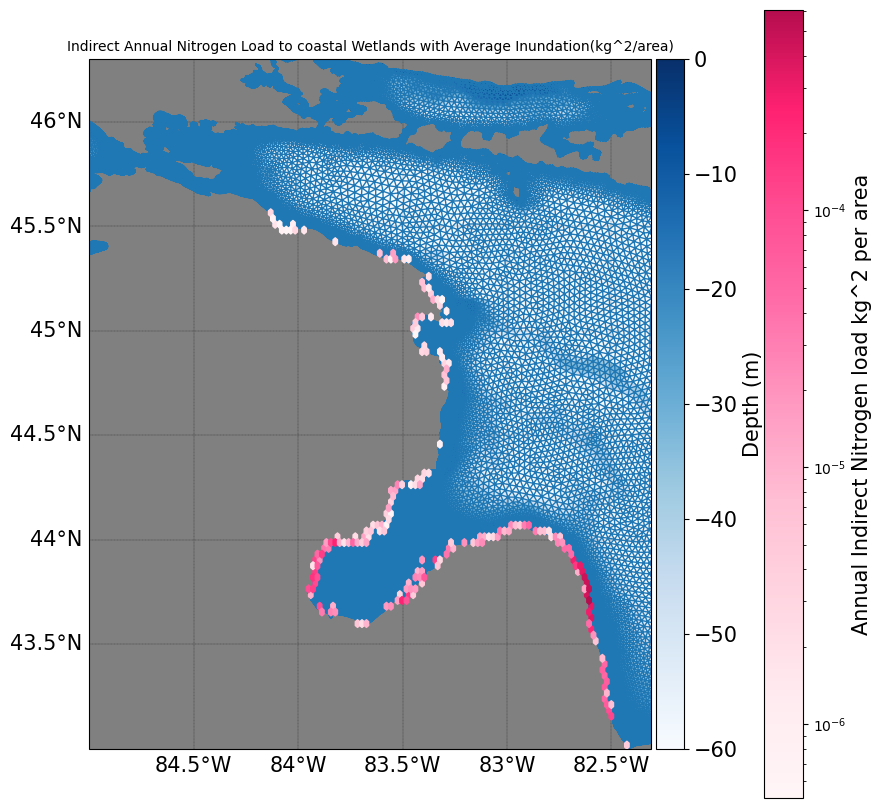

<Figure size 640x480 with 0 Axes>

In [89]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Collect all coordinates and WetLoad_TN_kg2 data for plotting
all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
wetload_tn = merged_data['WetLoad_TN_kg2'].values

# Plot settings
font_size = 15
cmap = pink_cmap

# Create the figure and axis using the FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data (assuming you have it in your dataset)
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)

# Overlay the grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot where bins reflect WetLoad_TN_kg2 concentration
hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tn, gridsize=80, cmap=cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

# Add color bar for WetLoad_TN_kg2 concentration
cbar = fig.colorbar(hb, ax=ax, pad=0.1)
cbar.set_label('Annual Indirect Nitrogen load kg^2 per area', fontsize=15)

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Indirect Annual Nitrogen Load to coastal Wetlands with Average Inundation(kg^2/area)', fontsize=10)
# Show the plot
plt.show()
plt.savefig(output_path + 'Indirect_Annual_Nitrogen_Load_to_Coastal_Wetlands_with_Average_Inundation.png', dpi=300)


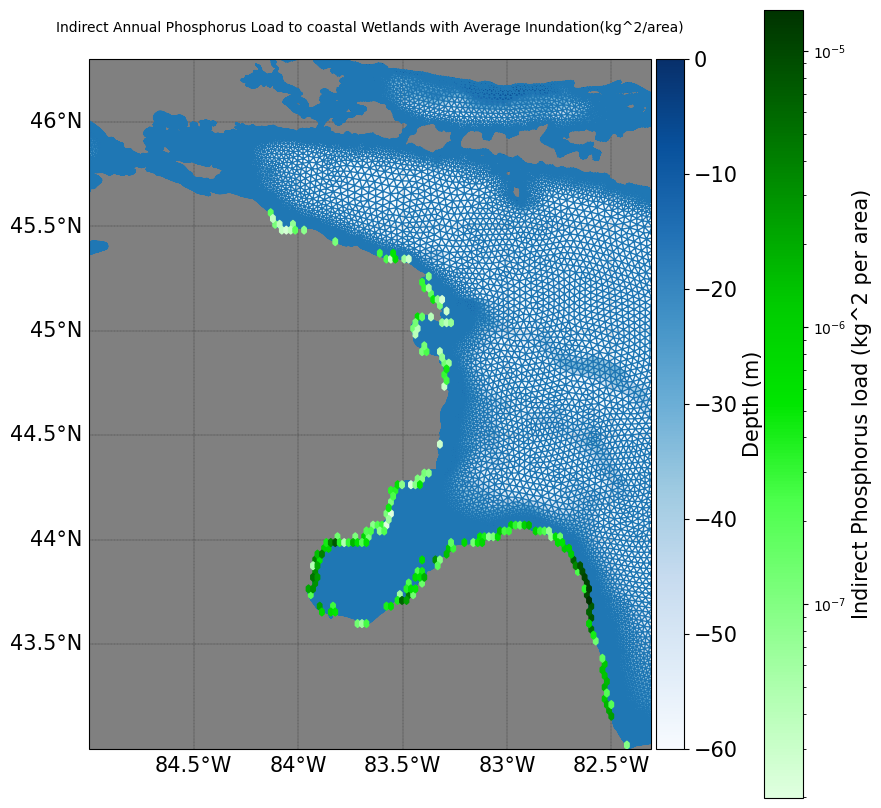

<Figure size 640x480 with 0 Axes>

In [90]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Collect all coordinates and WetLoad_TP_kg2 data for plotting
all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
wetload_tp = merged_data['WetLoad_TP_kg2'].values

# Plot settings
font_size = 15
cmap = green_cmap

# Create the figure and axis using the FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data (assuming you have it in your dataset)
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)

# Overlay the grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot where bins reflect WetLoad_TP_kg2 concentration
hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tp, gridsize=80, cmap=cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

# Add color bar for WetLoad_TP_kg2 concentration
cbar = fig.colorbar(hb, ax=ax, pad=0.1)
cbar.set_label('Indirect Phosphorus load (kg^2 per area)', fontsize=15)

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Indirect Annual Phosphorus Load to coastal Wetlands with Average Inundation(kg^2/area)', fontsize=10, pad=20)

# Show the plot
plt.show()
plt.savefig(output_path'Indirect_Annual_Phosphorus_Load_to_Coastal_Wetlands_with_Average_Inundation.png', dpi=300)